In [1]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
import numpy as np
import cv2

In [3]:
mask_model = load_model('Mask_detection_model.h5')
prototxt_path = 'deploy.prototxt'
weights_path = 'res10_300x300_ssd_iter_140000.caffemodel'
face_net = cv2.dnn.readNet(prototxt_path, weights_path) # deep neural network

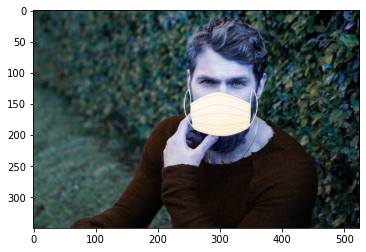

In [102]:
%matplotlib inline
import matplotlib.pyplot as plt
image = cv2.imread('..\Deep Learning\Open CV\Bro code.jpg')
image = cv2.imread('data/with_mask/with_mask_1.jpg')
# image = cv2.resize(image,(800,1000))
plt.imshow(image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


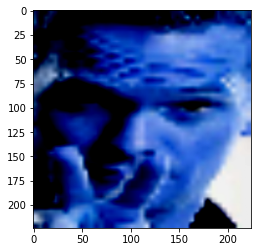

In [78]:
plt.imshow(face)

In [51]:
image.shape

(224, 224, 3)

In [79]:
t_image = cv2.imread('..\Deep Learning\Open CV\Bro code.jpg')
test = mask_model.predict(np.expand_dims(image, axis = 0))
# np.expand_dims(image, axis = 0).shape
print(test)

[[0.]]


In [121]:
image = cv2.imread('data/with_mask/with_mask_8.jpg')
(locs, preds) = detect_and_predict_mask(image, face_net, mask_model)
for (box, pred) in zip(locs, preds):
    # unpack the bounding box and predictions
    (startX, startY, endX, endY) = box
    # (mask, withoutMask) = pred
    # determine the class label and color we'll use to draw
    # the bounding box and text
    label = "Mask" if pred[0] < 0.5 else "No Mask"
    color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

    # include the probability in the label
    label = f"{label}"

    # display the label and bounding box rectangle on the output
    # frame
    cv2.putText(image, label, (startX, startY - 10),
        cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
    cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)
cv2.imshow("image", image)
cv2.waitKey(0)

(1, 1, 200, 7)
[[0.02119508]
 [0.9726739 ]]


-1

In [107]:
cv2.destroyAllWindows()

In [43]:
preds

array([[0.76045555]], dtype=float32)

In [83]:
def detect_and_predict_mask(frame, faceNet, mask_model):
	# grab the dimensions of the frame and then construct a blob
	# from it
	(h, w) = frame.shape[:2]
	blob = cv2.dnn.blobFromImage(frame, 1.0, (224, 224)
		# ,(104.0, 177.0, 123.0)
		)

	# pass the blob through the network and obtain the face detections
	faceNet.setInput(blob)
	detections = faceNet.forward()
	print(detections.shape)

	# initialize our list of faces, their corresponding locations,
	# and the list of predictions from our face mask network
	faces = []
	locs = []
	preds = []

	# loop over the detections
	for i in range(0, detections.shape[2]):
		# extract the confidence (i.e., probability) associated with
		# the detection
		confidence = detections[0, 0, i, 2]

		# filter out weak detections by ensuring the confidence is
		# greater than the minimum confidence
		if confidence > 0.5:
			# compute the (x, y)-coordinates of the bounding box for
			# the object
			box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
			(startX, startY, endX, endY) = box.astype("int")

			# ensure the bounding boxes fall within the dimensions of
			# the frame
			(startX, startY) = (max(0, startX), max(0, startY))
			(endX, endY) = (min(w - 1, endX), min(h - 1, endY))

			# extract the face ROI, convert it from BGR to RGB channel
			# ordering, resize it to 224x224, and preprocess it
			face = frame[startY:endY, startX:endX]
			face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
			face = cv2.resize(face, (224, 224))
			face = img_to_array(face)
			face = preprocess_input(face)
			# add the face and bounding boxes to their respective
			# lists
			faces.append(face)
			locs.append((startX, startY, endX, endY))

	# only make a predictions if at least one face was detected
	if len(faces) > 0:
		# for faster inference we'll make batch predictions on *all*
		# faces at the same time rather than one-by-one predictions
		# in the above `for` loop
		faces = np.array(faces, dtype="float32")
		# print(faces)
		preds = mask_model.predict(faces, batch_size=32)
		print(preds)

	# return a 2-tuple of the face locations and their corresponding
	# locations
	return (locs, preds)

In [5]:
webcam = cv2.VideoCapture(0) # set 0 to select the main webcam
webcam.set(3,640) # 3 sets the width
webcam.set(4,480) # 4 sets the height
# webcam.set(10,100) # 10 sets brightness
faceCascade= cv2.CascadeClassifier(r"project_env\Lib\site-packages\cv2\data\haarcascade_frontalface_default.xml")

while True:
    success, img = webcam.read()
    image_grey = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces = faceCascade.detectMultiScale(image_grey,1.1,4)
    for (x,y,w,h) in faces:
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
        target = img[y:y+h, x:x+w]
        target = cv2.resize(target,(224,224))
        target = np.expand_dims(target, axis = 0)
        if mask_model.predict(target)[0][0] > 0.5:
            cv2.putText(img, "Mask", (int(x),int(y+h+10)), cv2.FONT_ITALIC, 1, (255,0,0), 1) # scale, colour, thickness
        else:
            cv2.putText(img, "Without Mask", (int(x),int(y+h+10)), cv2.FONT_ITALIC, 1, (255,0,0), 1) # scale, colour, thickness
        cv2.imshow("Webcam", img)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        cv2.destroyAllWindows()
        break

In [40]:
mask_model.predict(target)

array([[1.]], dtype=float32)